In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from scipy.spatial.distance import cdist
from scipy.spatial import distance

In [ ]:
SELECTED_IMAGE = 3 # 1, 2, 3, 4 or 5

In [ ]:
sel = str(SELECTED_IMAGE + 5)

if SELECTED_IMAGE == 5:
  image_bgr = cv2.imread("C1_000010.png")
  image_nir = cv2.imread("C0_000010.png",cv2.IMREAD_GRAYSCALE)
else:
  image_bgr = cv2.imread("C1_00000" + sel + ".png")
  image_nir = cv2.imread("C0_00000" + sel + ".png",cv2.IMREAD_GRAYSCALE)

The first step is to threshold the image. In order to extract the kiwi from the background in this case is used the OTSU thresholding after a blurring step.

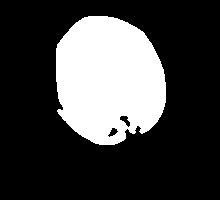

In [ ]:
#blur the images
blurred_image = cv2.GaussianBlur(image_nir, (7, 7), 0) 

#threshold images
th_image = cv2.threshold(blurred_image, 40, 255, cv2.THRESH_BINARY * cv2.THRESH_OTSU)[1]
cv2_imshow(th_image)

Now that the image is thresholded we want to identify the kiwi contour in order to create its mask. To do that is identified the largest area contour of the thresholded image.

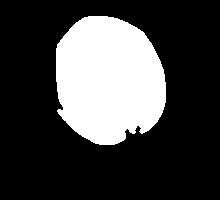

In [ ]:
contours, hierarchy = cv2.findContours(th_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

def argmax_contour(contours):
  maxArea = 0
  argmax_area = None
  for i,c in enumerate(contours):
    if cv2.contourArea(c) > maxArea:
      maxArea = cv2.contourArea(c)
      argmax_area = i
  return argmax_area

blank=np.zeros(image_nir.shape, np.uint8)
cnt = contours[argmax_contour(contours)]
cv2.drawContours(blank, [cnt], 0, (255,255,255), 1)
cv2.fillPoly(blank, pts =[cnt], color=(255,255,255))
cv2_imshow(blank)

Then we ca apply the mask and extract the kiwi's pixels.

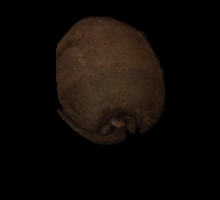

In [ ]:
masked_image = cv2.bitwise_and(image_bgr, image_bgr, mask=blank)
cv2_imshow(masked_image)

Then is performed a canny's edge detector to detect defects inside the kiwi.

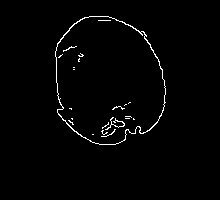

In [ ]:
canny= cv2.Canny(masked_image,70,95)
cv2_imshow(canny)

The contours of the kiwi is avoided by subtracting the diltation of the background.

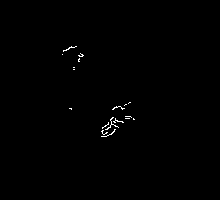

In [ ]:
background = 255 - blank
kernel = np.ones((5, 5), np.uint8)
background_dilated = cv2.dilate(background, kernel, iterations=3)
defects = cv2.subtract(canny, background_dilated)
cv2_imshow(defects)

Applying a closing action using as structuring element an ellipse, allows to unify the edge's identified by the canny's edge detector.

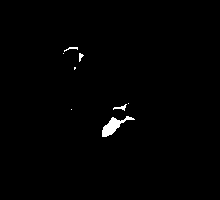

In [ ]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
closed = cv2.morphologyEx(defects, cv2.MORPH_CLOSE, structuringElement)
cv2_imshow(closed)

Now the defects identified must be filtered to avoid false positives. This is done by checking the area of each defect found.

In [ ]:
contours, hierarchy = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
good_contours = []
for c in contours:
  if cv2.contourArea(c) > 230:
    good_contours.append(c)

Finnaly the true defects are highlightetd through a bounding box.

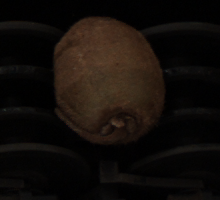

In [ ]:
for c in good_contours:
  rect = cv2.minAreaRect(c)
  box = cv2.boxPoints(rect)
  box = np.int0(box)
  cv2.drawContours(image_bgr,[box],0,(0,0,255),2)
cv2_imshow(image_bgr)